# ARIMA Models:

##### ARIMA stands for AutoRegressive Integrated Moving Average. 
ARIMA models use a combination of multiple regression on the past values and moving averages of the past residuals to generate forecasts

##### The ARIMA models have 3 important components called the order of the model;
* p: which is the order of the autoregressive part and designates the number of past observations to take into account
* d: which is the order of differencing that is applied to the data
* q: which is the order of the moving average part and designates the number of past residuals to take into account

components for generating forecasts. These components and their calculations vary based on the method used.

##### Seasonal ARIMA (SARIMA) models are an extension of ARIMA Models that factor in seasonality
##### SARIMA models also have a seasonal order with 3 components;
* p: which is the order of the seasonal autoregressive part and designates the number past seasonal lags to take into account
* d: which is the order of seasonal differencing that is applied to the data
* q: which is the order of the moving average part and designates the number of past seasonal residuals to take into account

##### Seasonal components of a SARIMA Model can be thought as an ARIMA model that applies it's component with a lag of seasonality period

In [1]:
#Import pandas for loading a time series dataframe and matplotlib for some plotting
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the Air Passengers Data
#https://www.kaggle.com/rakannimer/air-passengers
df = pd.read_csv("../datasets/AirPassengers.csv", index_col=0)
df

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


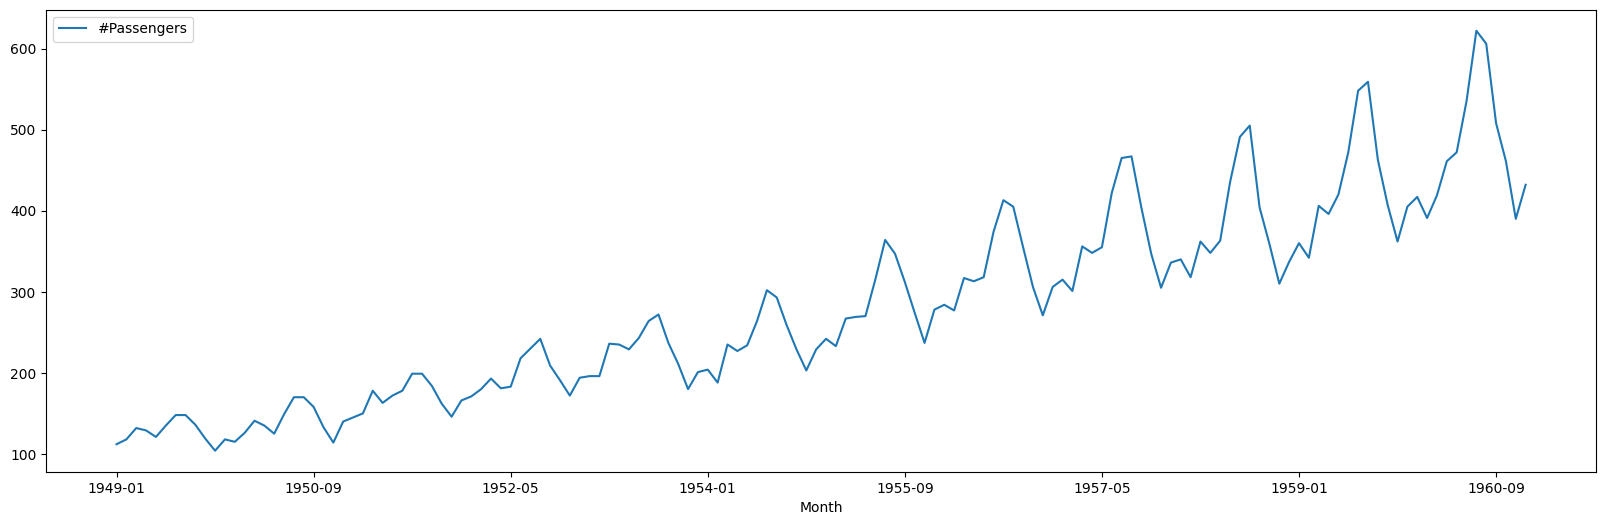

In [3]:
#Plot to visualize the time series data
df.plot(figsize=(20,6))
plt.show()

### ARIMA models

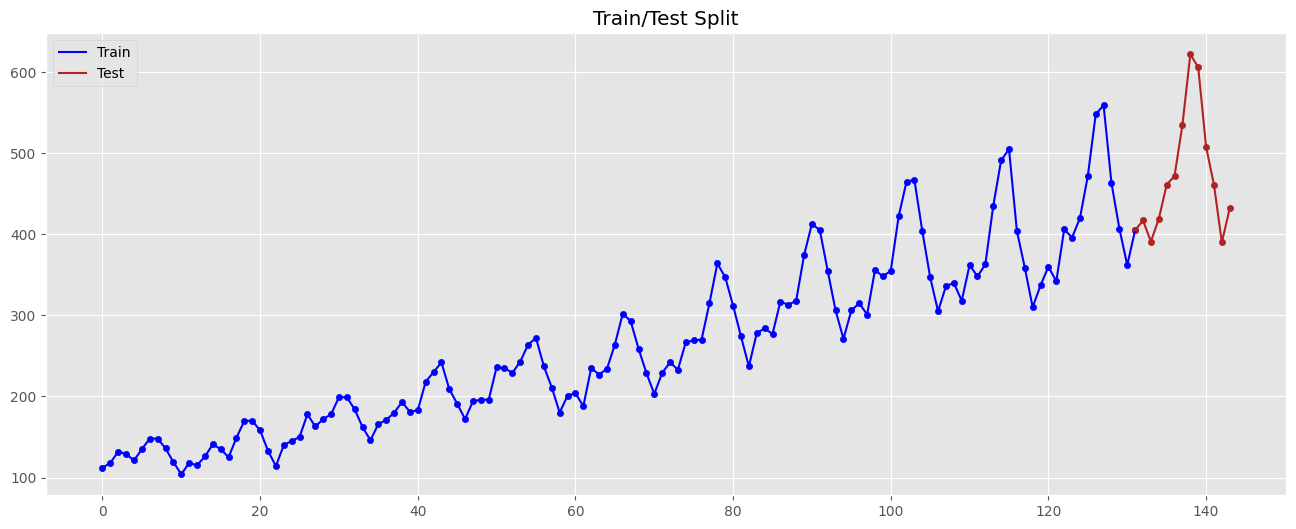

In [4]:
#Before fitting the models, split the data into training and testing;
#We will take the last year of data to test the results of the models
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]

#Plot the data by calling plot_train_test_split() function from chronokit.utils module
from chronokit.utils import plot_train_test_split
#Take a smaller part of the training data to visualize the test data better
plot_train_test_split(train_data=df_train, test_data=df_test, figsize=(16,6), colors=["blue", "red"], style="ggplot", title="Train/Test Split")

#### Data Scaling

##### Modeling leads to different results depending on the scale of the data
##### Our data ranges from 100 to 600s; so scaling it may lead to better results
##### We'll use BoxCox transformation; which is a type of power transformation to scale the data
* y_scaled = (y**lambda - 1)/lambda if lambda != 0 else ln(y)

* [wikipedia page on Box-Cox](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation)

In [5]:
from chronokit.preprocessing import BoxCox

#Instantiate the boxcox transformation class
bc_scaler = BoxCox()

#Scale the training data by estimating lambda (scaling parameter)
scaled_train = bc_scaler.transform(df_train)

#Scale the test data by using the lambda value estimated during scaling the training data
#Transformation classes store their scaling parameters after each scaling
#By providing lambda_values = bc_scaler.lambdas; we use the same lambda used during scaling the train data
scaled_test = bc_scaler.transform(df_test, lambda_values=bc_scaler.lambdas)

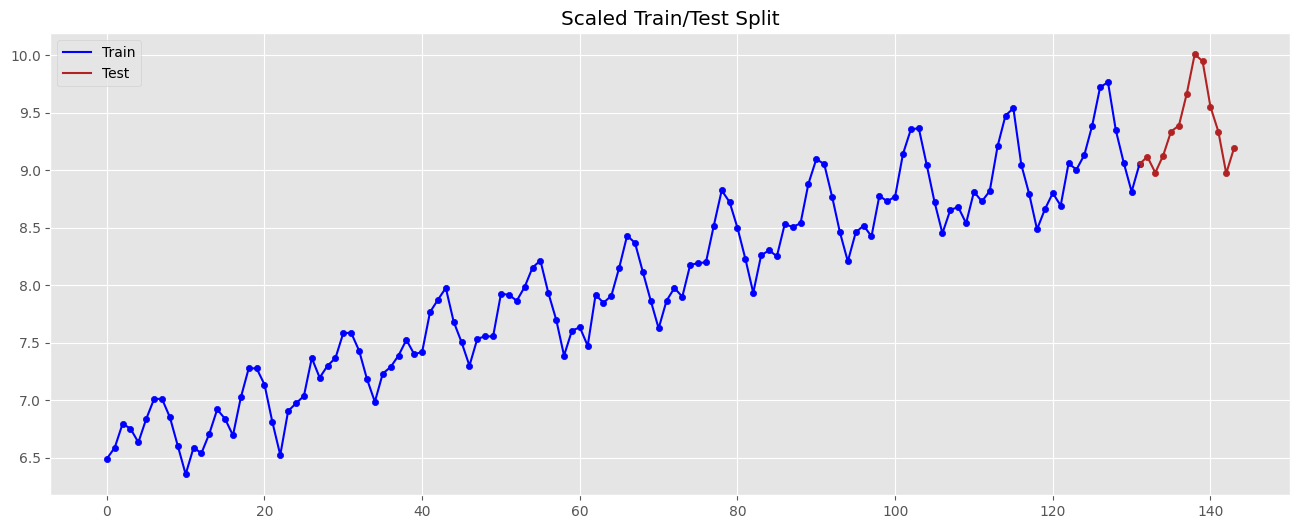

In [6]:
#Our data is now on a much better scale, while still preserving its "shape"
plot_train_test_split(train_data=scaled_train, test_data=scaled_test, figsize=(16,6), colors=["blue", "red"], style="ggplot", 
                      title="Scaled Train/Test Split")

In [7]:
from chronokit.arima import SARIMA

#Initialize the ARIMA model

#ARIMA models are designed for stationary time series data
#So we will include differencing by defining an order of (p, 1, q) to make the data stationary
#First let's try a simple ARIMA(1,1,1) model (without any seasonality)
arima_model = SARIMA(data=scaled_train, order=(1, 1, 1))

In [8]:
#We can see some info about the model by its .info attribute
arima_model.info

{'model': 'ARIMA_(1, 1, 1)',
 'AR_Order': 1,
 'Difference_Order': 1,
 'MA_Order': 1,
 'Seasonal': False,
 'num_params': 2}

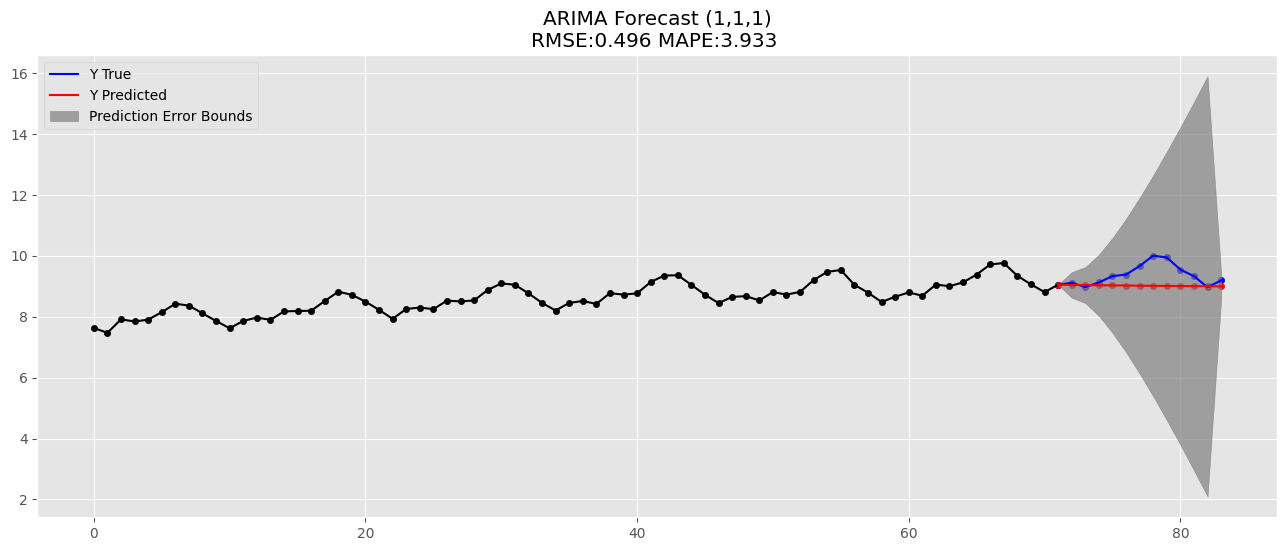

In [9]:
#Visualize the results by calling plot_predictions() from chronokit.utils module
from chronokit.utils import plot_predictions

#Fit the model to the training data
arima_model.fit()

#For forecasting, call the .predict() method with providing the forecasting horizon (h) as the argument
fc, bounds = arima_model.predict(h=12, confidence=0.95)

#Visualize the predictions
plot_predictions(y_true=scaled_test, y_pred=fc, bounds=bounds,
                 pre_vals=scaled_train[-72:],
                 colors=["blue", "red"], 
                 title="ARIMA Forecast (1,1,1)", 
                 metrics=["rmse", "mape"])

We can see that the results are subpar

Since ARIMA(1,1,1) model only uses the last observation and last observed error;

It's not enough to model a seasonal series with a period of 12

In [10]:
#Now, let's try by introducing seasonal orders
#We'll again use an order of (1,1,1); together with a seasonal order of(1,1,1) and period 12
sarima_model = SARIMA(data=scaled_train, order=(1, 1, 1),
                      seasonal_order=(1,1,1), seasonal_periods=12)

sarima_model.info

{'model': 'SARIMA_(1, 1, 1)_(1, 1, 1)12',
 'AR_Order': 1,
 'Difference_Order': 1,
 'MA_Order': 1,
 'Seasonal': True,
 'Seasonal_Order': (1, 1, 1),
 'Seasonal Period': 12,
 'num_params': 4}

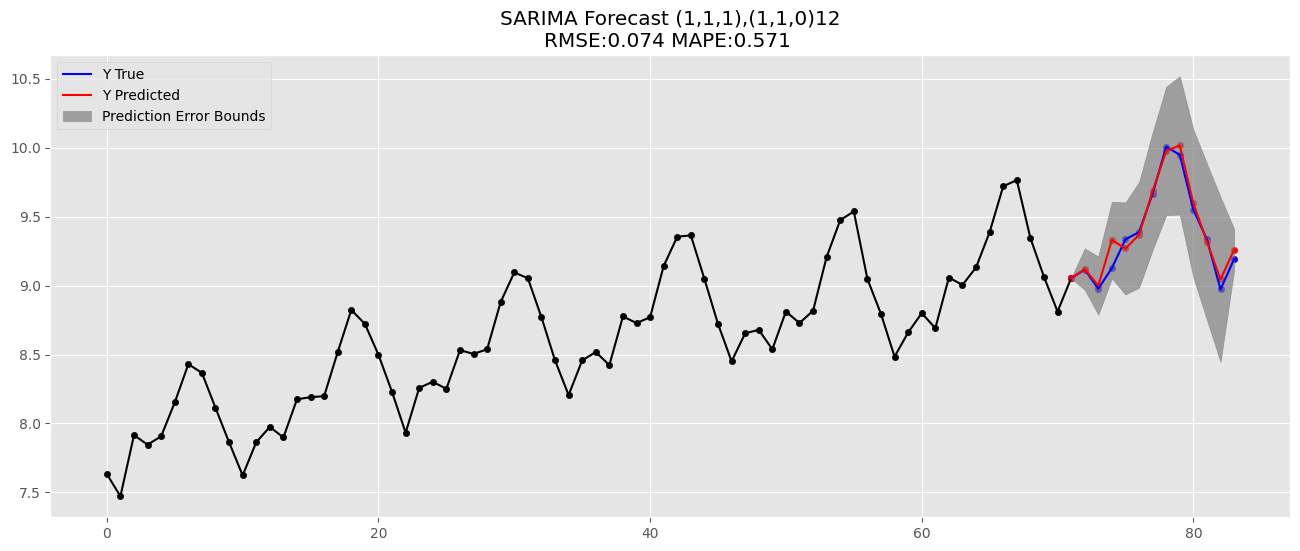

In [11]:
#Fit and get forecasts
sarima_model.fit()
fc, bounds = sarima_model.predict(h=12, confidence=0.95)

#We have achieved a huge performance increase by introducing seasonality
plot_predictions(y_true=scaled_test, y_pred=fc, bounds=bounds,
                 pre_vals=scaled_train[-72:],
                 colors=["blue", "red"], 
                 title="SARIMA Forecast (1,1,1),(1,1,0)12", 
                 metrics=["rmse", "mape"])

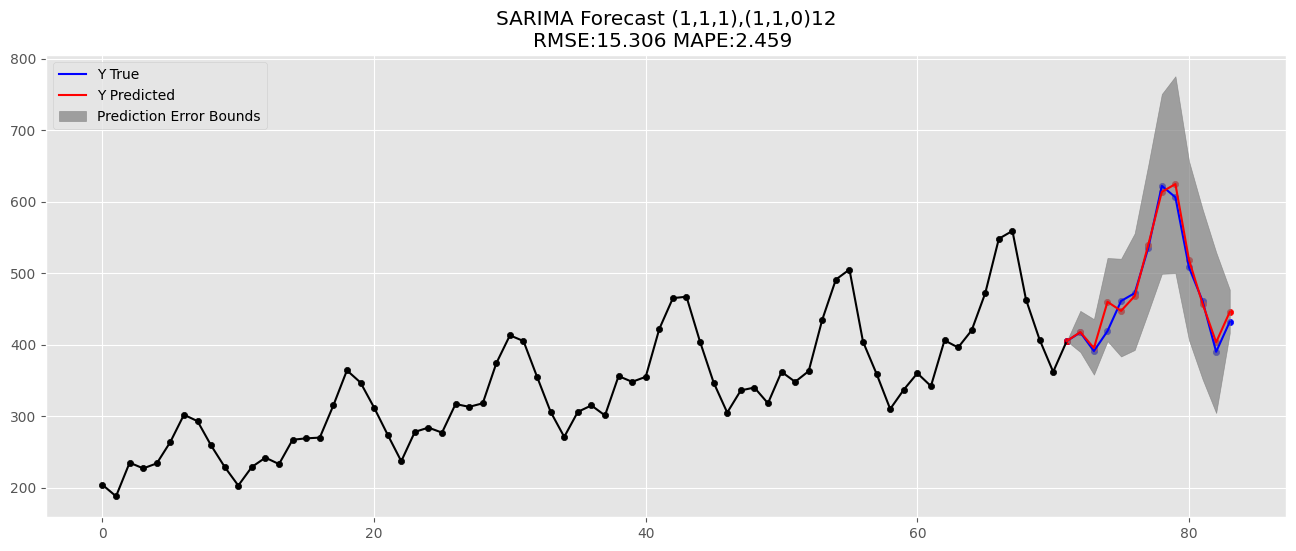

In [12]:
#Let's compare the results on the original scale
fc, bounds = sarima_model.predict(h=12, confidence=0.95)

#Inverste transform the forecasts and forecast bounds to the original scale
fc = bc_scaler.inverse_transform(fc)
upper_bound = bc_scaler.inverse_transform(bounds[0])
lower_bound = bc_scaler.inverse_transform(bounds[1])

plot_predictions(y_true=df_test, y_pred=fc, bounds=(upper_bound, lower_bound),
                 pre_vals=df_train[-72:],
                 colors=["blue", "red"], 
                 title="SARIMA Forecast (1,1,1),(1,1,0)12", 
                 metrics=["rmse", "mape"])